In [15]:
import pandas as pd
import numpy as np
import itertools
import math
import sys
sys.path.insert(0, '../..')

import matplotlib.pyplot as plt

from g4l.data import Sample
import g4l.display
from g4l.tree import ContextTree

#cache_dir = '../example1/cache'

In [16]:
# Create a sample object instance
X = Sample('../example1/publico.txt', [0, 1, 2, 3, 4])
t = ContextTree(X, max_depth=4)

In [17]:
df = t.df.copy()
# initialize
df.final = 1
df['children_contrib'] = df.transition_sum_log_probs
df.loc[df.lps==0, 'children_contrib'] = -math.inf

In [18]:
# mark all nodes in the last level as leaves
df['type'] = 'N' # simple node

max_node_length = df.l.max() # 4
df.loc[df.l==max_node_length, 'type'] = 'L' # (mark as leaf)

In [19]:
df_results = pd.DataFrame(columns=['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx'])
df_results.node_idx = df_results.node_idx.astype(object)

In [20]:
# iteration block

iteration_num = 0
while df.final.sum()>0:
    # fetch all nodes connected to leaf nodes and mark them as parent of leaves (LP)
    parent_node_idx = df.loc[(df.final==1) & (df.type=='L')].parent_idx.unique()
    df.loc[df.node_idx.isin(parent_node_idx), 'type'] = 'LP' # leaf parent

    # for all LP nodes, mark as candidate those ones that connects only with leaf nodes
    lp_nodes = df.loc[(df.type=='LP') & (df.final==1)]
    for idx, lp_node in lp_nodes.iterrows():
        child_nodes = df[df.parent_idx==lp_node.node_idx]

        num_child_nodes = len(child_nodes)
        active_child_nodes = (child_nodes.final==1).astype(int).sum()
        leaf_nodes = (child_nodes.type=='L').astype(int).sum()
        # when all child nodes are leaves and active
        if num_child_nodes == active_child_nodes == leaf_nodes:
            df.loc[df.node_idx==lp_node.node_idx, 'type'] = 'LPC' # mark these nodes as candidates (LPC)

    lpc = df[df.type=='LPC']
    if len(lpc)==0:
        break
    
    # for all the candidate nodes (LPC), calculate the less contributive
    less_contributive_lp_idx = np.array(lpc.sort_values(['children_contrib']).node_idx)[0]    
    
    # Eliminate leaves
    df.loc[df.parent_idx==less_contributive_lp_idx, 'final'] = 0

    # The less contributive LPC becomes a leaf
    df.loc[df.node_idx==less_contributive_lp_idx, 'type'] = 'L'
    iteration_num += 1

    active_nodes = df[df.final==1]
    # ['iter_num', 'num_nodes', 'log_likelihood_sum', 'node_idx']
    df_results.loc[len(df_results)] = [iteration_num, len(active_nodes), active_nodes[active_nodes.type=='L'].lps.sum(), np.array(active_nodes.node_idx)]

In [21]:
x = df_results.sort_values(['log_likelihood_sum'], ascending=False).node_idx[:1]
nodes_idx = x.to_numpy()[0]
new_df = t.df.copy()
new_df = new_df[new_df.node_idx.isin(nodes_idx)]
new_df.final = 1
new_t = ContextTree(X, max_depth=4, source_data_frame=new_df)

In [22]:
g4l.display.draw_tree(new_t.to_str(), size='40')
# the last iteration has length=1 

In [23]:
new_t.df

,l,node_idx,len_idx,parent_idx,node,node_freq,lps,transition_probs,transition_sum_log_probs,flag,final
0,1,0,0,None,0,46674,-66685.630033,"[0.22603590864292755, 0.29125423147791063, 0.3...",-9.311966,0,1
1,1,1,1,None,1,23847,-20436.033116,"[0.6923302721516333, 0.0, 0.21491172893865057,...",-8.354481,0,1
2,1,2,2,None,2,23847,-16294.669579,"[0.5700507401350274, 0.4299492598649725, 0.0, ...",-1.406118,0,1
3,1,3,3,None,3,8685,-7262.864788,"[0.6931491076568796, 0.0, 0.19447322970639033,...",-9.686943,0,1
4,1,4,4,None,4,2273,-1468.123271,"[0.0, 0.0, 0.6524417069951606, 0.3471183457985...",-1.485123,0,1
...,...,...,...,...,...,...,...,...,...,...,...
745,4,745,590,148,0334,3,-1.909543,"[0.0, 0.0, 0.3333333333333333, 0.6666666666666...",-1.504077,0,1
746,4,746,591,148,1334,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,1
747,4,747,592,148,2334,0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0,1
748,4,748,593,148,3334,1,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0]",0.000000,0,1


In [24]:
results = df_results.sort_values(['num_nodes'], ascending=True)

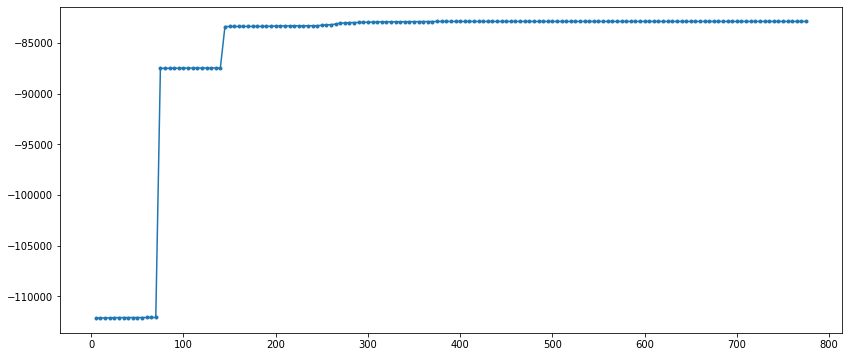

,iter_num,num_nodes,log_likelihood_sum,node_idx
154,155,5,-112147.320788,"[0, 1, 2, 3, 4]"
153,154,10,-112145.136732,"[0, 1, 2, 3, 4, 25, 26, 27, 28, 29]"
152,153,15,-112142.860113,"[0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 145, 146, ..."
151,152,20,-112141.997067,"[0, 1, 2, 3, 4, 25, 26, 27, 28, 29, 145, 146, ..."
150,151,25,-112111.355612,"[0, 1, 2, 3, 4, 15, 16, 17, 18, 19, 25, 26, 27..."
...,...,...,...,...
4,5,755,-82891.311275,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,4,760,-82891.311275,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,3,765,-82891.311275,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,770,-82891.311275,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [28]:
plt.figure(figsize=(14, 6))
plt.plot(results.num_nodes, results.log_likelihood_sum, marker='.')
plt.show()
results

In [26]:
t.log_likelihood()


-365594.09482525924

In [27]:
t.num_contexts()

780